# Predicting Movie Box Office Revenue: A Machine Learning Approach
## Team SZA - Final Project

**Team Members:** Savannah Day, Zachary Zambrana, Amer, Dhivya Venkatachalam

**Dataset:** Movies Box Office Dataset (2000-2024) from Kaggle

**Source:** https://www.kaggle.com/datasets/aditya126/movies-box-office-dataset-2000-2024

---

#### Data Provenance

 - Primary Source: Box Office Mojo (IMDbPro/Amazon)
 - Data Collector: Kaggle user "aditya126" (data aggregator)
 - Collection Method: Web scraping + TMDB API enrichment
 - Time Period: 2000-2024 (25 years)
 - Sample Size: 5,000 movies (top performers by year)  

#### Data Governance
- Box Office Mojo information is made public by movie studios and theaters
- The TMDB data (genres, ratings, votes) is crowd sourced and verified
- Limitation: Revenue amounts are only estimates, actual contracts might differ
- Bias: Data is only on successful movies (top 200 each year), and it does not include small indie films

Box Office Mojo is industry-standard (used by Variety, Hollywood Reporter)

While box office datasets are commonly analyzed, this project focuses specifically on actionable studio decision-making. Rather than just predicting success/failure, we predict actual revenue amounts and identify which factors (genre, market split, ratings) drive profitability. This enables studios to make data-driven budget allocation, marketing strategy, and greenlight decisions before production begins.

Box office prediction is a problem that has received considerable attention, but classification is predominantly used. The regression technique enables detailed forecasting for box office returns. We will examine how different machine-learning approaches (distance-oriented approaches such as KNN, linear models, and tree models) can unveil underlying box office patterns.

---

#### Project Overview

In this project, we use machine learning to predict movie box office revenue and provide actionable insights for studio decision-making. The project compares three algorithms to determine which factors drive box office success.
 - KNN Regression
 - Linear Regression
 - Decision Tree 

### What We Did:

1. Data Loading and Cleaning - Kaggle API integration and dataset download, Column standardization and missing value handling, Data quality verification
2. Exploratory Data Analysis - Revenue distribution analysis, Correlation between features, Genre and market performance patterns
3. Feature Engineering and Preprocessing - Genre one-hot encoding, Domestic/foreign percentage calculations, Train/test split (70/30), StandardScaler normalization, Median imputation for missing values
4. Model Selection and Justification
   - KNN Regression: Distance-based pattern recognition
   - Linear Regression: Simple interpretable relationships
   - Decision Tree: Capture complex feature interactions
5. Model Training and Evaluation- Metrics: MAE, RMSE, R² for all models
6. Results interpretation

---
## Importing the Data and Preparation

In [2]:
import os, glob, re
import pandas as pd
from kaggle.api.kaggle_api_extended import KaggleApi

# Authenticate
api = KaggleApi()
api.authenticate()

# Choose the folder
download_dir = r'D:\MLKaggleProject\movies_dataset'  # <- folder
os.makedirs(download_dir, exist_ok=True)

# Download & unzip into that folder
api.dataset_download_files(
    "aditya126/movies-box-office-dataset-2000-2024",
    path=download_dir,
    unzip=True
)

print("Files in folder:", os.listdir(download_dir))

# Load the first CSV found
csv_files = glob.glob(os.path.join(download_dir, "*.csv"))
if csv_files:
    df = pd.read_csv(csv_files[0])
    print("Loaded:", csv_files[0])
    print(df.head())
else:
    print("No CSVs found. Check the folder listing above.")

Dataset URL: https://www.kaggle.com/datasets/aditya126/movies-box-office-dataset-2000-2024
Files in folder: ['enhanced_box_office_data(2000-2024)u.csv']
Loaded: D:\MLKaggleProject\movies_dataset\enhanced_box_office_data(2000-2024)u.csv
   Rank           Release Group   $Worldwide    $Domestic  Domestic %  \
0     1  Mission: Impossible II  546388108.0  215409889.0        39.4   
1     2               Gladiator  460583960.0  187705427.0        40.8   
2     3               Cast Away  429632142.0  233632142.0        54.4   
3     4         What Women Want  374111707.0  182811707.0        48.9   
4     5                Dinosaur  349822765.0  137748063.0        39.4   

      $Foreign  Foreign %  Year                        Genres    Rating  \
0  330978219.0       60.6  2000   Adventure, Action, Thriller  6.126/10   
1  272878533.0       59.2  2000      Action, Drama, Adventure  8.217/10   
2  196000000.0       45.6  2000              Adventure, Drama  7.663/10   
3  191300000.0       51.1

## Data Loading

In [3]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from matplotlib.colors import ListedColormap
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_text
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report,ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

# Set style for beautiful visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

In [4]:
# What file did we load and what are its columns?
print("CSV path:", csv_files[0] if csv_files else "None")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head(3))
display(df.sample(3, random_state=42))

CSV path: D:\MLKaggleProject\movies_dataset\enhanced_box_office_data(2000-2024)u.csv
Shape: (5000, 13)
Columns: ['Rank', 'Release Group', '$Worldwide', '$Domestic', 'Domestic %', '$Foreign', 'Foreign %', 'Year', 'Genres', 'Rating', 'Vote_Count', 'Original_Language', 'Production_Countries']


,Rank,Release Group,$Worldwide,$Domestic,Domestic %,$Foreign,Foreign %,Year,Genres,Rating,Vote_Count,Original_Language,Production_Countries
0,1,Mission: Impossible II,546388108.0,215409889.0,39.4,330978219.0,60.6,2000,"Adventure, Action, Thriller",6.126/10,6741.0,en,United States of America
1,2,Gladiator,460583960.0,187705427.0,40.8,272878533.0,59.2,2000,"Action, Drama, Adventure",8.217/10,19032.0,en,"United Kingdom, United States of America"
2,3,Cast Away,429632142.0,233632142.0,54.4,196000000.0,45.6,2000,"Adventure, Drama",7.663/10,11403.0,en,United States of America


,Rank,Release Group,$Worldwide,$Domestic,Domestic %,$Foreign,Foreign %,Year,Genres,Rating,Vote_Count,Original_Language,Production_Countries
1501,102,We Own the Night,55033767.0,28563179.0,51.9,26470588.0,48.1,2007,"Drama, Crime, Thriller",6.695/10,1367.0,en,United States of America
2586,187,I Want You,23961214.0,0.0,0.0,23961214.0,100.0,2012,"Drama, Romance",7.432/10,1880.0,es,Spain
2653,54,Escape Plan,137328301.0,25135965.0,18.3,112192336.0,81.7,2013,"Action, Thriller",6.726/10,5148.0,en,"United Kingdom, United States of America"


## Data Cleaning

In [5]:
#Fixing Readability
df.rename(columns={
    '$Worldwide': 'Worldwide_Gross',
    '$Domestic': 'Domestic_Gross',
    'Domestic %': 'Domestic_Pct',
    '$Foreign': 'International_Gross',
    'Foreign %': 'International_Pct'
}, inplace=True)
display(df.head(1))

,Rank,Release Group,Worldwide_Gross,Domestic_Gross,Domestic_Pct,International_Gross,International_Pct,Year,Genres,Rating,Vote_Count,Original_Language,Production_Countries
0,1,Mission: Impossible II,546388108.0,215409889.0,39.4,330978219.0,60.6,2000,"Adventure, Action, Thriller",6.126/10,6741.0,en,United States of America


In [6]:
# Cleaning Numeric Data and %'s
money_cols = ['Worldwide_Gross', 'Domestic_Gross', 'International_Gross']
for col in money_cols:
    df[col] = df[col].replace('[\$,]', '', regex=True).astype(float)

percent_cols = ['Domestic_Pct', 'International_Pct']

for col in percent_cols:
    # Convert to float
    df[col] = df[col].astype(float)
    
    # Only divide by 100 if the max value > 1 (meaning it's in 0–100 scale)
    if df[col].max() > 1:
        df[col] = df[col] / 100

df.columns = [c.strip().lower() for c in df.columns]

display(df.head(1))

,rank,release group,worldwide_gross,domestic_gross,domestic_pct,international_gross,international_pct,year,genres,rating,vote_count,original_language,production_countries
0,1,Mission: Impossible II,546388108.0,215409889.0,0.394,330978219.0,0.606,2000,"Adventure, Action, Thriller",6.126/10,6741.0,en,United States of America


In [7]:
#Figuring out how to handle the rating value
if 'rating' is not None:
    df["rating"] = (
        df['rating'].astype(str)
        .str.extract(r'([\d\.]+)', expand=False)  # specifically go and grab the numeric part
        .astype(float)
    )
else:
    df["rating"] = np.nan  # will be dropped if fully missing

# Keep just the columns we’ll use downstream (drop rows missing target)
work = df[[
    'worldwide_gross', 'domestic_gross', 'international_gross',
    'domestic_pct', 'international_pct',
    'rating', 'year', 'genres'
]].copy()

work.rename(columns={'worldwide_gross': 'revenue'}, inplace=True)
work = work.dropna(subset=['revenue']).copy()

work.head()

,revenue,domestic_gross,international_gross,domestic_pct,international_pct,rating,year,genres
0,546388108.0,215409889.0,330978219.0,0.394,0.606,6.126,2000,"Adventure, Action, Thriller"
1,460583960.0,187705427.0,272878533.0,0.408,0.592,8.217,2000,"Action, Drama, Adventure"
2,429632142.0,233632142.0,196000000.0,0.544,0.456,7.663,2000,"Adventure, Drama"
3,374111707.0,182811707.0,191300000.0,0.489,0.511,6.450,2000,"Comedy, Romance"
4,349822765.0,137748063.0,212074702.0,0.394,0.606,6.544,2000,"Animation, Family, Adventure"


## Exploratory Data Analysis (EDA)
    
Exploring the data to understand the distribution of the target variable revenue and relationships between the features

1. Reveune Distibution 
2. Revenue Sanity Check
3. Correlation HeatMap

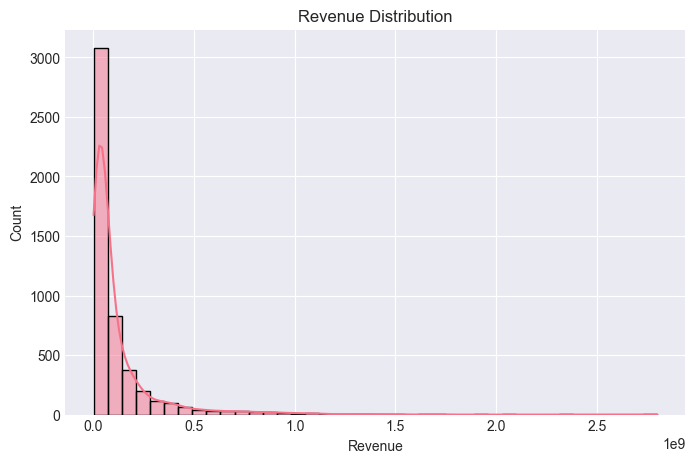

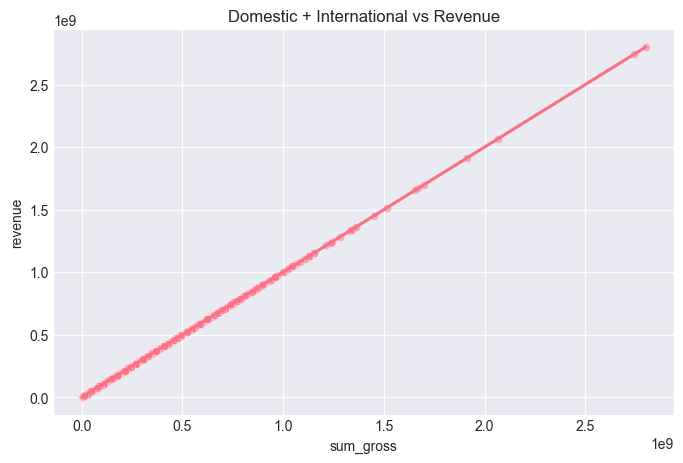

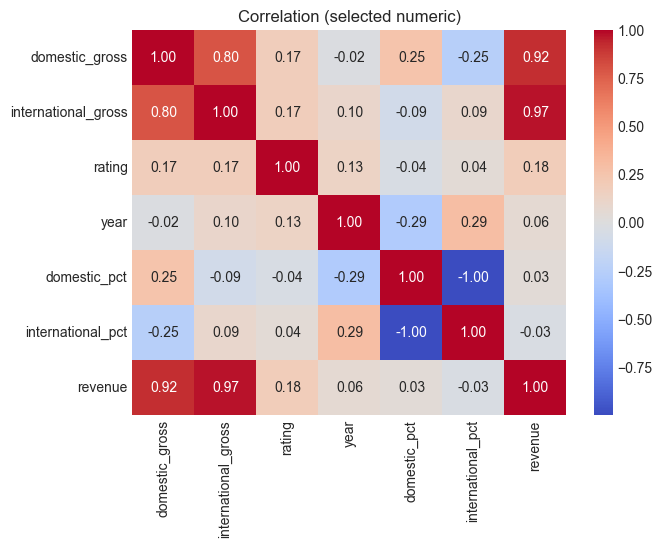

In [8]:
# Revenue distribution
plt.figure(figsize=(8,5))
sns.histplot(work['revenue'], bins=40, kde=True)
plt.title("Revenue Distribution")
plt.xlabel("Revenue")
plt.ylabel("Count")
plt.show()

if {'domestic_gross','international_gross'}.issubset(work.columns):
    tmp = work.dropna(subset=['domestic_gross','international_gross'])
    tmp = tmp.assign(sum_gross = tmp['domestic_gross'] + tmp['international_gross'])
    sample = tmp if len(tmp) <= 3000 else tmp.sample(3000, random_state=42)
    plt.figure(figsize=(8,5))
    sns.scatterplot(data=sample, x='sum_gross', y='revenue', alpha=0.5)
    sns.regplot(data=sample, x='sum_gross', y='revenue', scatter=False, ci=None)
    plt.title("Domestic + International vs Revenue")
    plt.show()

# Correlation (available numeric)
num_cols = [c for c in ['domestic_gross','international_gross','rating','year','domestic_pct','international_pct','revenue'] if c in work.columns]
if len(num_cols) >= 2:
    plt.figure(figsize=(7,5))
    sns.heatmap(work[num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation (selected numeric)")
    plt.show()

**Interpretation:**

These graphs show that there are very few movies that actuall make billions in revenue, most wont even crack anything over 10-20 Million as shown in the histogram.
There also seems to be some positive corelations between things like revenue and domestic and international gross revenue. Theres a slight correlation between rating and year, domestic and international gross revenue.

## Feature Engineering & Selection

In [9]:
import re

features = []

# Numeric features that exist
for c in ['domestic_gross','international_gross','rating','year','domestic_pct','international_pct']:
    if c in work.columns:
        features.append(c)

# Multi-hot encode top 15 genres
if 'genres' in work.columns:
    exploded = (
        work['genres'].astype(str)
        .str.split('[,|/]')
        .explode()
        .str.strip()
        .str.lower()
    )
    top15 = exploded.value_counts().head(15).index.tolist()
    for g in top15:
        col = f'genre_{g}'
        work[col] = work['genres'].astype(str).str.contains(rf'\b{re.escape(g)}\b', case=False, na=False).astype(int)
        features.append(col)

print("Using features:", features)

X = work[features].copy()
y = work['revenue'].copy()

Using features: ['domestic_gross', 'international_gross', 'rating', 'year', 'domestic_pct', 'international_pct', 'genre_drama', 'genre_comedy', 'genre_action', 'genre_adventure', 'genre_thriller', 'genre_romance', 'genre_crime', 'genre_family', 'genre_fantasy', 'genre_science fiction', 'genre_animation', 'genre_horror', 'genre_mystery', 'genre_history', 'genre_nan']


## Data Preprocessing

 - Splitting - Train-Test Split with training set of about 80% and a testing set  of about 20%
 - Imputing - Using Simple Imputer to fill the missing values using median (robust for KNN). We fit imputing only on training data to prevent the data leakage.
 - Scaling - Ensuring all features are qually weighted in distance calculation

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Impute any remaining missing numerics with median (robust for KNN)
imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train)
X_test_imp  = imputer.transform(X_test)

# Scale (critical for distance-based KNN)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_imp)
X_test_s  = scaler.transform(X_test_imp)

In [11]:
# Initialize results storage
results = []

def evaluate_model(name, mae, rmse, r2):
        return {
        'Model Name': name,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'R²': round(r2, 3)
    }

## Model - KNN Regressor

Business Use Case:
Before committing to finance or produce a project, studios require a projection of revenues to establish budget parameters. Below is a business use case that answers the question:
"What is the expected global box office revenue based on a movie’s date and type?"

Why KNN Regressor

-   It recreates real-world industry behavior directly related to "finding comps (short for comparable films).”
-   The logic is simple: Similar movies will have similar box office performance. It can identify nonlinearity between category pairs and revenues which a simple model cannot.

In KNN Regressor:

 - Training the KNN model to predict the revenue starting with n_neighbors k=5
 - Fitting on the scaled data and predicting the revenues on the unseen test data
 - Evaluating the model with three regression metrics

Metrics Choosen:

   - MAE (Mean Absolute Error) - average amount in dollars that our prediction is off by
   - RMSE (Root Mean Squared Error) - metric that penalizes tge large errors heavily
   - R^2 - R-squared - percentage of the variance in revenue that our model explains


Baseline KNN (k=5, weights='distance')  |  MAE: 37,126,612  RMSE: 63,412,642  R²: 0.914


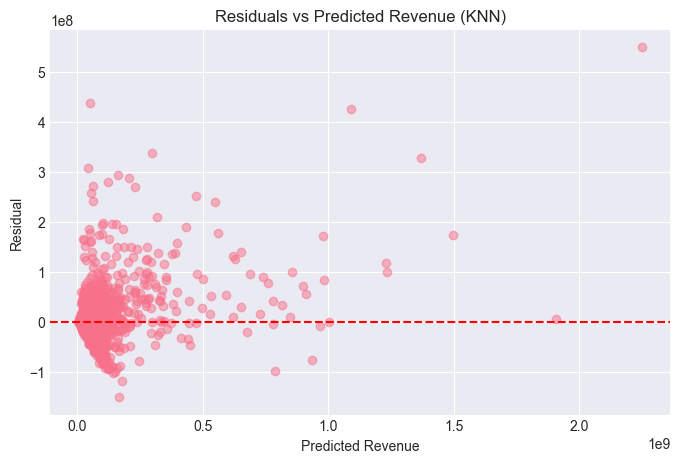

In [12]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

knn = KNeighborsRegressor(n_neighbors=5, weights='distance')
knn.fit(X_train_s, y_train)
pred = knn.predict(X_test_s)

mae  = mean_absolute_error(y_test, pred)
rmse = sqrt(mean_squared_error(y_test, pred))
r2   = r2_score(y_test, pred)

results.append(evaluate_model("KNN (k=5)", mae, rmse, r2))
print(f"Baseline KNN (k=5, weights='distance')  |  MAE: {mae:,.0f}  RMSE: {rmse:,.0f}  R²: {r2:.3f}")

# Residual plot
resid = y_test - pred
plt.figure(figsize=(8,5))
plt.scatter(pred, resid, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Revenue (KNN)")
plt.xlabel("Predicted Revenue")
plt.ylabel("Residual")
plt.show()

**Interpretation:**

R-Squared - Our Model's features explains 91.4% of the variance in movie revenue

RMSE - On average, the model's revenue prediction if off by about $63.4 million

This shows us that most of the values fall between 1 and -1 of the perfect prediction line. While not ideal it was expected that we wouldnt recieve a perfect model. Points over this line were underestimated revenue and points under the line were overestimated revenue. The model tends to underestimate revenue for extremely successful blockbusters, suggesting that those outliers are not well represented in the training data.

### Hyperparameter Tuning: Finding the Optimal k


Best k by RMSE: 3


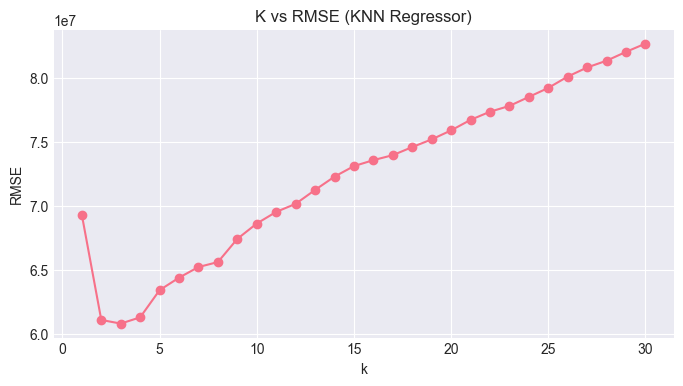

Best-k Metrics → MAE: 36,609,524 | RMSE: 60,798,661 | R²: 0.921


In [13]:
ks = range(1, 31)
rmse_list = []
for k in ks:
    m = KNeighborsRegressor(n_neighbors=k, weights='distance')
    m.fit(X_train_s, y_train)
    rmse_list.append(sqrt(mean_squared_error(y_test, m.predict(X_test_s))))

best_k = list(ks)[int(np.argmin(rmse_list))]
print("Best k by RMSE:", best_k)

plt.figure(figsize=(8,4))
plt.plot(list(ks), rmse_list, marker='o')
plt.title("K vs RMSE (KNN Regressor)")
plt.xlabel("k")
plt.ylabel("RMSE")
plt.show()

best_knn = KNeighborsRegressor(n_neighbors=best_k, weights='distance').fit(X_train_s, y_train)
best_pred = best_knn.predict(X_test_s)

mae = mean_absolute_error(y_test, best_pred)
rmse = sqrt(mean_squared_error(y_test, best_pred))
r2 = r2_score(y_test, best_pred)

print(
    f"Best-k Metrics → MAE: {mae:,.0f} | "
    f"RMSE: {rmse:,.0f} | "
    f"R²: {r2:.3f}"
)

results.append(evaluate_model(f"KNN (best_k={best_k})", mae, rmse, r2))

**Interpretation:**

The more neighbors that are used in the analysis of the data, the worse the model becomes. The sweetspot is from 2-5 I picked 3 because it gave the best option. Anything over this we risk the model being inaccurate.

### Example Scenario: Predicting a Action Movie

 - Taking the median value of all features from training data to create a new example movie and setting manually a action genre
 - Predicting the revenue from our best_knn model

In [14]:
# Build an example from median values of train set
X_train_df = pd.DataFrame(X_train_imp, columns=X.columns, index=X_train.index)
example = X_train_df.median(numeric_only=True)

# Zero all genre flags; optionally enable one
for c in X.columns:
    if c.startswith('genre_'):
        example[c] = 0
if 'genre_action' in X.columns:
    example['genre_action'] = 1  # simulate an Action movie

example_df = pd.DataFrame([example], columns=X.columns)
example_s  = scaler.transform(imputer.transform(example_df))
pred_example = best_knn.predict(example_s)[0]
print(f"Predicted revenue for example row: ${pred_example:,.0f}")
example_df.head(1)

Predicted revenue for example row: $33,479,418


,domestic_gross,international_gross,rating,year,domestic_pct,international_pct,genre_drama,genre_comedy,genre_action,genre_adventure,...,genre_romance,genre_crime,genre_family,genre_fantasy,genre_science fiction,genre_animation,genre_horror,genre_mystery,genre_history,genre_nan
0,17678513.0,29851403.5,6.6,2012.0,0.368,0.632,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Interpretation**

After training tuning and testing our model, the KNN model predicted $33,479,418 in revenue and the actual revenue was $47,529,916.5 
This is off and would probably require some more training and parameter tuning but is not too much of a far cry from the actual ammount of revenue that was made. 
I think there are better models out there to deploy in order to predict some metric like this. 

### Predicting Revenue by Genre

 - Building a movie having median value of all features from the training set having single genre for each movie
 - Training the model and predicting the revenue using knn model

In [15]:
# Rebuild a median baseline movie (all numeric medians)
X_train_df = pd.DataFrame(X_train, columns=X.columns)
base_example = X_train_df.median(numeric_only=True)

# Collect predicted revenue for each genre
genre_cols = [c for c in X.columns if c.startswith('genre_')]
predicted_revenues = {}

for genre_col in genre_cols:
    example = base_example.copy()
    # turn all genres off, then turn one on
    for g in genre_cols:
        example[g] = 0
    example[genre_col] = 1
    
    # transform and predict
    ex_df = pd.DataFrame([example], columns=X.columns)
    ex_scaled = scaler.transform(imputer.transform(ex_df))
    pred_rev = best_knn.predict(ex_scaled)[0]
    predicted_revenues[genre_col.replace('genre_', '').title()] = pred_rev

# Convert to DataFrame and sort
genre_preds = pd.DataFrame.from_dict(predicted_revenues, orient='index', columns=['Predicted_Revenue'])
genre_preds = genre_preds.sort_values('Predicted_Revenue', ascending=False)

print(genre_preds.head(10))

                 Predicted_Revenue
Family                1.149551e+08
Horror                1.067167e+08
Science Fiction       1.042383e+08
Nan                   7.691550e+07
Fantasy               7.496331e+07
Comedy                7.342923e+07
Drama                 6.750630e+07
Mystery               5.724649e+07
Adventure             5.344891e+07
Thriller              4.803033e+07


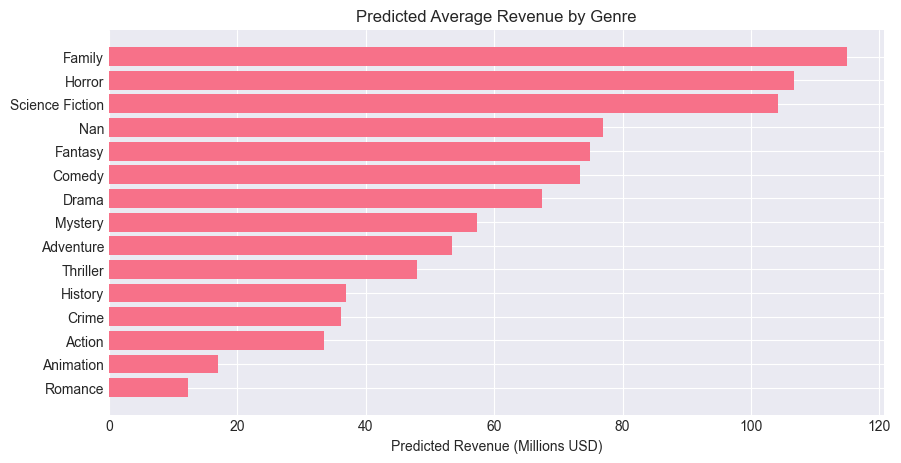

In [16]:
#plotting these results
plt.figure(figsize=(10,5))
plt.barh(genre_preds.index, genre_preds['Predicted_Revenue']/1e6)
plt.gca().invert_yaxis()
plt.title("Predicted Average Revenue by Genre")
plt.xlabel("Predicted Revenue (Millions USD)")
plt.show()

**Interpretation**

This shows that the most profitable movies to make according to the model and the training that was done are Family movies, then horror and finally science fiction. It is obviously an issue that the Nan category is ranked so high but there was too much data to impede all these values and they were either not listed in the dataset or were not able to be classified. This doesnt represent a single genre but essentially every movie that showe Nan in the genre category was placed in here which likely artificially inflated this category and it should be ingored. 

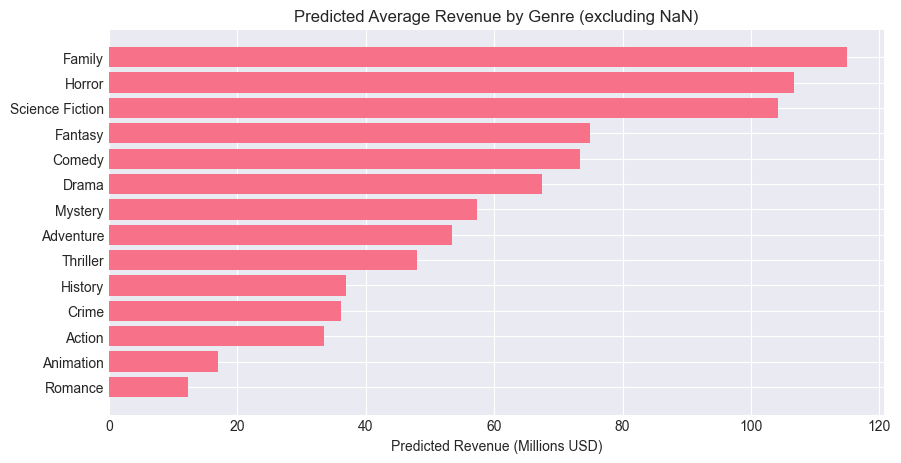

In [17]:
genre_preds_no_nan = genre_preds[genre_preds.index.str.lower() != 'nan']

plt.figure(figsize=(10,5))
plt.barh(genre_preds_no_nan.index, genre_preds_no_nan['Predicted_Revenue']/1e6)
plt.gca().invert_yaxis()
plt.title("Predicted Average Revenue by Genre (excluding NaN)")
plt.xlabel("Predicted Revenue (Millions USD)")
plt.show()

This is the data if we wanted to present it in a business case and leave out the detail of the options that didnt have genres available. 

## Linear Regression

Business Context: 
Studios must estimate final global box office revenues after each opening weekend to inform decisions on:
 - Additional marketing investment
 - Global expansion of movie releases and sequel developments

Why Linear Regression?
 - Interpretable coefficients for one-dollar-revenue relationships
 - Fast computation for real-time decision-making
 - Well-established for forecasting financial data in other industries

Metrics Chosen:
 - R² (Coefficient of Determination) - % of Revenue Variances Explained - Describes forecasting ability
 - RMSE (Root Mean Squared Error) - Average Error - Budget Risk in Millions
 - MAE (Mean Absolute Error) - Typical Deviation - Also easier to understand


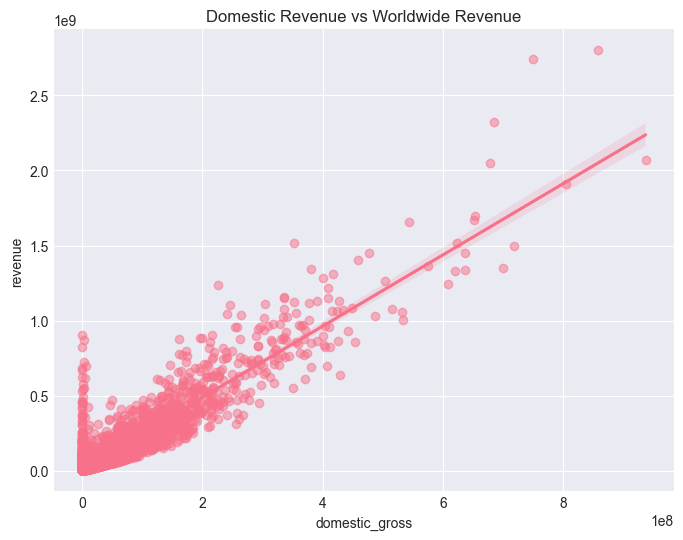

In [18]:
#Linear regression: Domestic vs Worldwide 
plt.figure(figsize=(8,6))
sns.regplot(x="domestic_gross", y="revenue", data=work, scatter_kws={'alpha':0.5})
plt.title("Domestic Revenue vs Worldwide Revenue")
plt.show()


**Interpretation:**

From the scatterplot of Domestic gross vs Worldwide gross having linear regression line, it visualizes the positive linear relationship between revenue and domestic gross. This explains how well the domestic gross explains the worldwide revenue


In [19]:
# Model lr: Domestic Revenue → Worldwide Revenue
from sklearn.linear_model import LinearRegression

X_domestic = work[['domestic_gross']].dropna()
y_worldwide = work.loc[X_domestic.index, 'revenue']
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_domestic, y_worldwide, test_size=0.2, random_state=42)

lr_domestic = LinearRegression()
lr_domestic.fit(X_train_d, y_train_d)
y_pred_d = lr_domestic.predict(X_test_d)

rmse_d = np.sqrt(mean_squared_error(y_test_d, y_pred_d))
mae_d = mean_absolute_error(y_test_d, y_pred_d)
r2_d = r2_score(y_test_d, y_pred_d)

results.append(evaluate_model(f"LR(Domestic Vs Worldwide revenue)", mae_d, rmse_d, r2_d))

print("LINEAR REGRESSION: Domestic → Worldwide")
print("-----------------------------------------------")
print(f"R² Score:  {r2_d:.4f}  (explains {r2_d*100:.1f}% of variance)")
print(f"RMSE:      ${rmse_d/1e6:.2f}M  (average error in millions)")
print(f"MAE:       ${mae_d/1e6:.2f}M  (typical deviation)")
print(f"\nInterpretation: For every $1M domestic, worldwide increases by ${lr_domestic.coef_[0]/1e6:.2f}M")

LINEAR REGRESSION: Domestic → Worldwide
-----------------------------------------------
R² Score:  0.8505  (explains 85.1% of variance)
RMSE:      $83.50M  (average error in millions)
MAE:       $48.77M  (typical deviation)

Interpretation: For every $1M domestic, worldwide increases by $0.00M


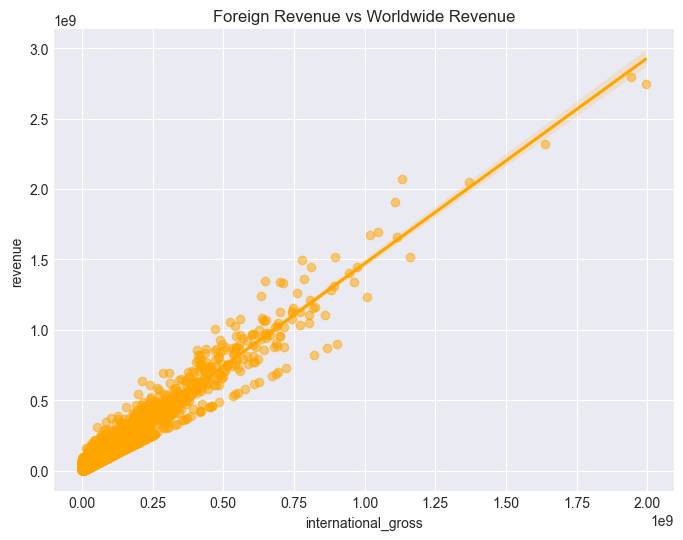

In [20]:
#Linear Regression: Foreign vs Worldwide
plt.figure(figsize=(8,6))
sns.regplot(x="international_gross", y="revenue", data=work, scatter_kws={'alpha':0.5}, color='orange')
plt.title("Foreign Revenue vs Worldwide Revenue")
plt.show()


**Interpretation**

From the scatterplot of International gross vs Worldwide gross having linear regression line, it visualizes the positive linear relationship between revenue and domestic gross. This explains how well the movie's foriegn performance predict the total revenue.

In [21]:
# Model lr: Foreign Revenue → Worldwide Revenue
X_foreign = work[['international_gross']].dropna()
y_worldwide_f = work.loc[X_foreign.index, 'revenue']
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_foreign, y_worldwide_f, test_size=0.2, random_state=42)

lr_foreign = LinearRegression()
lr_foreign.fit(X_train_f, y_train_f)
y_pred_f = lr_foreign.predict(X_test_f)

rmse_f = np.sqrt(mean_squared_error(y_test_f, y_pred_f))
mae_f = mean_absolute_error(y_test_f, y_pred_f)
r2_f = r2_score(y_test_f, y_pred_f)

results.append(evaluate_model(f"LR(Foriegn Vs Worldwide revenue)", mae_f, rmse_f, r2_f))

print("LINEAR REGRESSION: Foreign → Worldwide")
print("----------------------------------------------------")
print(f"R² Score:  {r2_f:.4f}  (explains {r2_f*100:.1f}% of variance)")
print(f"RMSE:      ${rmse_f/1e6:.2f}M")
print(f"MAE:       ${mae_f/1e6:.2f}M")
print(f"\nInterpretation: For every $1M foreign, worldwide increases by ${lr_foreign.coef_[0]/1e6:.2f}M")

LINEAR REGRESSION: Foreign → Worldwide
----------------------------------------------------
R² Score:  0.9443  (explains 94.4% of variance)
RMSE:      $50.96M
MAE:       $31.75M

Interpretation: For every $1M foreign, worldwide increases by $0.00M


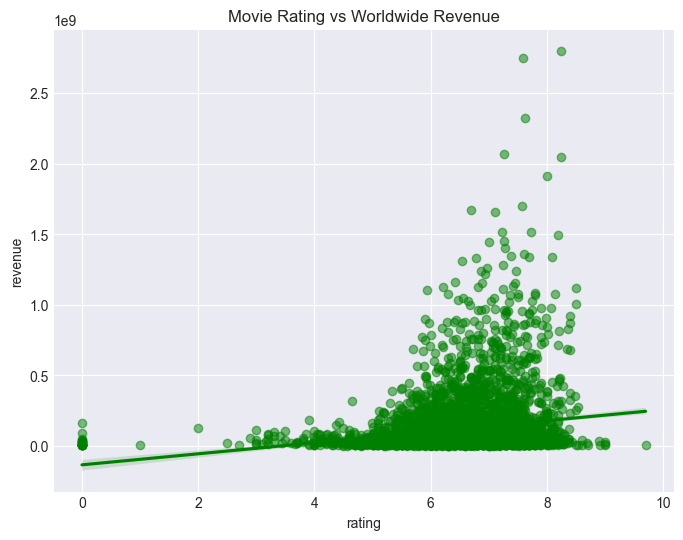

In [22]:
#Linear Regression: Rating vs Worldwide
plt.figure(figsize=(8,6))
sns.regplot(x="rating", y="revenue", data=work, scatter_kws={'alpha':0.5}, color='green')
plt.title("Movie Rating vs Worldwide Revenue")
plt.show()


**Interpretation**

From the scatterplot of rating vs Worldwide gross having linear regression line, it visualizes the weak positive correlation between revenue and domestic gross i.e., rating from 0-4 not had many massive hits and ratings ranging from 7-9 has huge variance in outcomes. They can be anything from low earning movie to blockbuster movie. This explains how the rating affects the revenue.

In [23]:
# Model lr: Rating → Worldwide Revenue (Testing the Rating Hypothesis)
X_rating = work[['rating']].dropna()
y_worldwide_r = work.loc[X_rating.index, 'revenue']
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_rating, y_worldwide_r, test_size=0.2, random_state=42)

lr_rating = LinearRegression()
lr_rating.fit(X_train_r, y_train_r)
y_pred_r = lr_rating.predict(X_test_r)

mae_r = mean_absolute_error(y_test_r, y_pred_r)
rmse_r = np.sqrt(mean_squared_error(y_test_r, y_pred_r))
r2_r = r2_score(y_test_r, y_pred_r)

results.append(evaluate_model(f"LR(Rating Vs Worldwide revenue)", mae_r, rmse_r, r2_r))

print("LINEAR REGRESSION: Rating → Worldwide")
print("---------------------------------------------------")
print(f"R² Score:  {r2_r:.4f}  (explains only {r2_r*100:.1f}% of variance)")
print(f"RMSE:      ${rmse_r/1e6:.2f}M")
print(f"MAE:       ${mae_r/1e6:.2f}M")
print(f"\nBusiness Insight: Rating is not a reliable predictor of financial reveune success")
print("High ratings ≠ High revenue. Studios cannot rely on critical acclaim alone.")

LINEAR REGRESSION: Rating → Worldwide
---------------------------------------------------
R² Score:  0.0250  (explains only 2.5% of variance)
RMSE:      $214.14M
MAE:       $119.06M

Business Insight: Rating is not a reliable predictor of financial reveune success
High ratings ≠ High revenue. Studios cannot rely on critical acclaim alone.


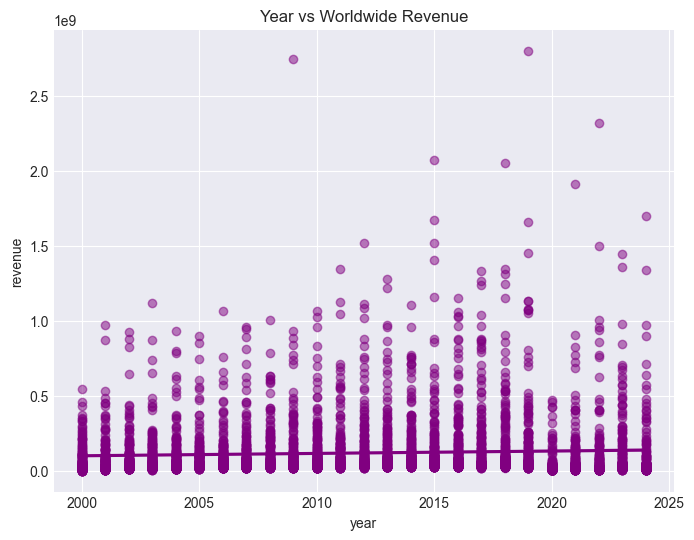

In [24]:
#Regression: Year vs Worldwide
plt.figure(figsize=(8,6))
sns.regplot(x="year", y="revenue", data=work, scatter_kws={'alpha':0.5}, color='purple')
plt.title("Year vs Worldwide Revenue")
plt.show()


**Interpretation:**

This plot explains whether the movies are becoming more profitable over time. From the plot, we could see the in the last few years consistent in revenue with few outliers.

In [25]:
#Regression: Year vs Worldwide
X_rating = work[['year']].dropna()
y_worldwide_y = work.loc[X_rating.index, 'revenue']
X_train_y, X_test_y, y_train_y, y_test_y = train_test_split(X_rating, y_worldwide_y, test_size=0.2, random_state=42)

lr_rating = LinearRegression()
lr_rating.fit(X_train_y, y_train_y)
y_pred_y = lr_rating.predict(X_test_y)

mae_y = mean_absolute_error(y_test_y, y_pred_y)
rmse_y = np.sqrt(mean_squared_error(y_test_y, y_pred_y))
r2_y = r2_score(y_test_y, y_pred_y)

results.append(evaluate_model(f"LR(Year Vs Worldwide revenue)", mae_y, rmse_y, r2_y))

print("LINEAR REGRESSION: Year → Worldwide")
print("---------------------------------------------------")
print(f"R² Score:  {r2_y:.4f}  (explains only {r2_y*100:.1f}% of variance)")
print(f"RMSE:      ${rmse_y/1e6:.2f}M")
print(f"MAE:       ${mae_y/1e6:.2f}M")
print(f"\nBusiness Insight: Year is not a reliable predictor of financial revenue success")

LINEAR REGRESSION: Year → Worldwide
---------------------------------------------------
R² Score:  0.0039  (explains only 0.4% of variance)
RMSE:      $215.58M
MAE:       $117.11M

Business Insight: Year is not a reliable predictor of financial revenue success


<Figure size 600x600 with 0 Axes>

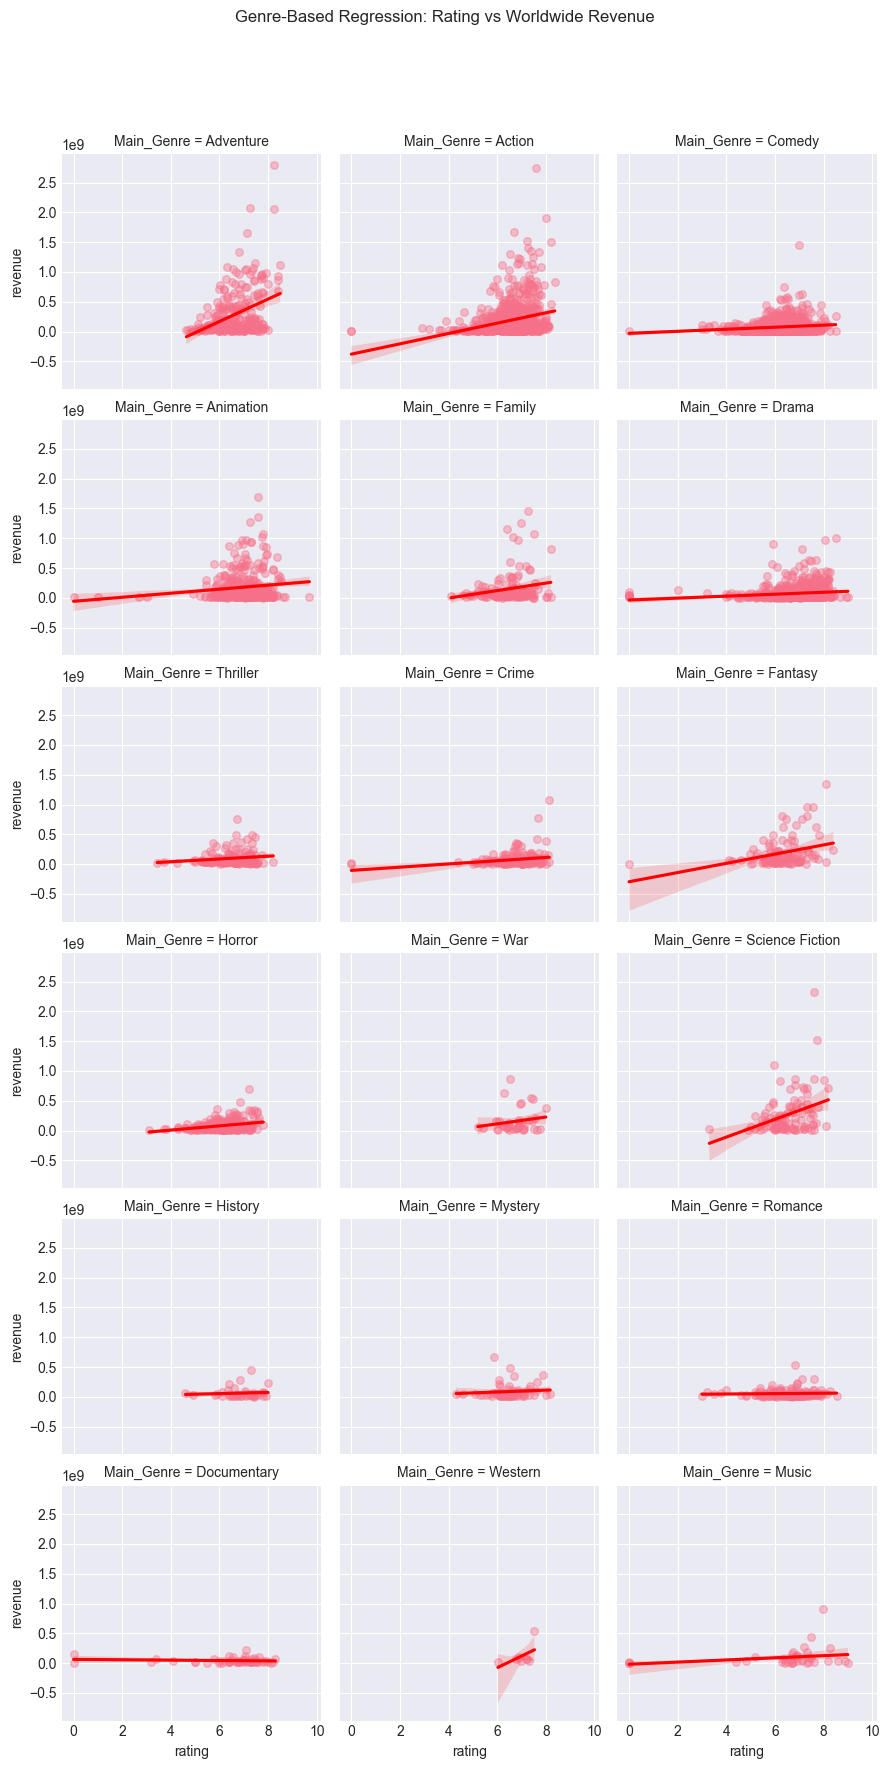

,revenue,domestic_gross,international_gross,domestic_pct,international_pct,rating,year,genres,genre_drama,genre_comedy,...,genre_crime,genre_family,genre_fantasy,genre_science fiction,genre_animation,genre_horror,genre_mystery,genre_history,genre_nan,Main_Genre
0,546388108.0,215409889.0,330978219.0,0.394,0.606,6.126,2000,"Adventure, Action, Thriller",0,0,...,0,0,0,0,0,0,0,0,0,Adventure
1,460583960.0,187705427.0,272878533.0,0.408,0.592,8.217,2000,"Action, Drama, Adventure",1,0,...,0,0,0,0,0,0,0,0,0,Action


In [26]:
#Regression: Genre vs Worldwide
plt.figure(figsize=(6, 6))
work["Main_Genre"] = work["genres"].apply(lambda x: x.split(",")[0].strip() if isinstance(x, str) else x)
sns.lmplot(
    x="rating",
    y="revenue",
    data=work,
    col="Main_Genre",
    col_wrap=3,
    scatter_kws={'alpha':0.4, 's':30},
    line_kws={'color':'red'},
    height=3
)
plt.subplots_adjust(top=0.9)
plt.suptitle("Genre-Based Regression: Rating vs Worldwide Revenue")
plt.show()

work.head(2)

**Interpretation:**

From the plots of each genre with worldwide revenue, Adventure, Action, Science fiction genre has the positive correlation between them and revenue with respect to rating. Rating has weak relationship when compared to documentries with revenue.

## Decision Tree

### Decision Tree Classifier

Business Use Case: To forecast audience quality (e.g., predict if a film will get a "Good" 7+ rating) before its release. This helps studios decide which films to greenlight and how to market them.

Why a Decision Tree? It's highly interpretable. It provides simple "if-then" rules that show why a prediction was made (e.g., "if genre is 'Animation', predict 'Liked'"), and it clearly identifies the most important features (like main_genre) driving a good rating.

Metrics:

 - Accuracy: The percentage of all rating predictions that were correct.
 - Precision: Of all films predicted to be "Liked," how many actually were.
 - Recall: Of all films that actually were "Liked," how many the model correctly identified.
 - F1-Score: The balanced average of precision and recall.


In [27]:
# Decision Tree
THRESHOLD = 7 # Setting the threshold to 7.

# Since decision trees give is a 'yes' or 'no' result, we'll set the liked to 1 if the rating is >=1.  Else, it becomes a 0 for disliked.
df["liked"] = (df["rating"] >= THRESHOLD).astype(int)

# We don't want to use revenue as a prediction indicator because it's closer to pre-release preference.
def first_token(x):
    if pd.isna(x): 
        return np.nan
    return str(x).split(",")[0].strip()
df["main_genre"] = df["genres"].apply(first_token)
df["main_country"] = df["production_countries"].apply(first_token)
# We want to keep the columns that will be best used
features_cat = ["main_genre", "original_language", "main_country"]
features_num = ["year", "vote_count"]
feature_cols = features_cat + features_num
# In case there's still NaN in rows, fill it with the median
for c in features_cat:
    df[c] = df[c].fillna("Unknown")
for c in features_num:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(df[c].median())

X = df[feature_cols].copy()
y = df["liked"].copy()

In [28]:
# Train/test split
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
# Decision tree using one-hot
# Decision trees dont need scaling
before_process = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), features_cat),],remainder="passthrough")
# randome state and starting limits to not have overfitting
clf = DecisionTreeClassifier(criterion="gini", max_depth=6, min_samples_leaf=50, random_state=42)
# Fitting the pipeline to export later
X_train_enc = before_process.fit_transform(X_train_dt)
X_test_enc  = before_process.transform(X_test_dt)
clf.fit(X_train_enc, y_train_dt)

# Evaluation
y_pred_dt = clf.predict(X_test_enc)
# Metrics of what we want
metrics = {
    "accuracy": accuracy_score(y_test_dt, y_pred_dt),
    "precision": precision_score(y_test_dt, y_pred_dt, zero_division=0),
    "recall": recall_score(y_test_dt, y_pred_dt, zero_division=0),
    "f1": f1_score(y_test_dt, y_pred_dt, zero_division=0)
}

print("Liked vs Unliked Decision Tree")
for k,v in metrics.items():
    print(f"{k.capitalize():>9}: {v:.3f}")


Liked vs Unliked Decision Tree
 Accuracy: 0.779
Precision: 0.674
   Recall: 0.510
       F1: 0.581


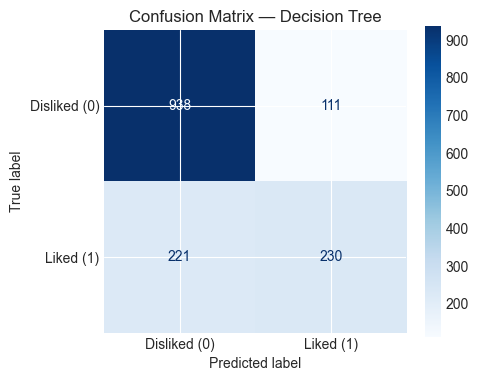


 The Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.89      0.85      1049
           1       0.67      0.51      0.58       451

    accuracy                           0.78      1500
   macro avg       0.74      0.70      0.72      1500
weighted avg       0.77      0.78      0.77      1500


Sample of Tree Rules For The First 5 Levels:
 |--- vote_count <= 7097.00
|   |--- main_genre_Drama <= 0.50
|   |   |--- year <= 2017.50
|   |   |   |--- original_language_ja <= 0.50
|   |   |   |   |--- main_genre_Crime <= 0.50
|   |   |   |   |   |--- original_language_ko <= 0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- original_language_ko >  0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- main_genre_Crime >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- original_language_ja >  0.50
|   |   |   |   |--- vote_count <= 70.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- vote_cou

In [29]:
cm = confusion_matrix(y_test_dt, y_pred_dt)
cm_dt = confusion_matrix(y_test_dt, y_pred_dt)
cmdisplay_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=['Disliked (0)','Liked (1)'])

# Confusion matrix display
fig, ax = plt.subplots(figsize=(5,4))
cmdisplay_dt.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Confusion Matrix — Decision Tree')
plt.tight_layout()
plt.show()
print("\n The Classification Report:\n", classification_report(y_test_dt, y_pred_dt, zero_division=0))

# Get final feature names from the column transformer.  Remember passthrough was last
ohe = before_process.named_transformers_["cat"]
cat_names = ohe.get_feature_names_out(features_cat).tolist()
final_feature_names = cat_names + features_num
print("\nSample of Tree Rules For The First 5 Levels:\n", export_text(clf, feature_names=final_feature_names, max_depth=5))


**Interpretation:**

From the confusion matrix, 
 - True Negatives TN - 938 - The model correclty predicts 938 movies as 'Disliked'
 - True Positives TP - 230 - The model correclty predicts 230 movies as 'Liked'
 - False Negatives FN - 221 - The model incorrectly predicts 'Disliked' that were actually liked
 - False Positives FP - 111 - The model incorrectly predicts 'Liked' that were actually disliked

From the classification report, model's overall accuracy is about 78%. Precision is about 67% in predicting the movie 'liked'. Recall is about 51% in identifing the actual movies 'Liked'. The mmodel is good at identifying at Disliked movies but not good at indentifying liked movies missing half of them.


 Most Feature Importance:
                         feature  importance
109                  vote_count    0.415700
6              main_genre_Drama    0.172599
108                        year    0.166054
35         original_language_ja    0.073977
2          main_genre_Animation    0.049835
26         original_language_en    0.047675
4              main_genre_Crime    0.037326
37         original_language_ko    0.025931
0             main_genre_Action    0.010903
5        main_genre_Documentary    0.000000
10            main_genre_Horror    0.000000
7             main_genre_Family    0.000000
8            main_genre_Fantasy    0.000000
9            main_genre_History    0.000000
13           main_genre_Romance    0.000000
12           main_genre_Mystery    0.000000
11             main_genre_Music    0.000000
14   main_genre_Science Fiction    0.000000
18           main_genre_Western    0.000000
19    original_language_Unknown    0.000000


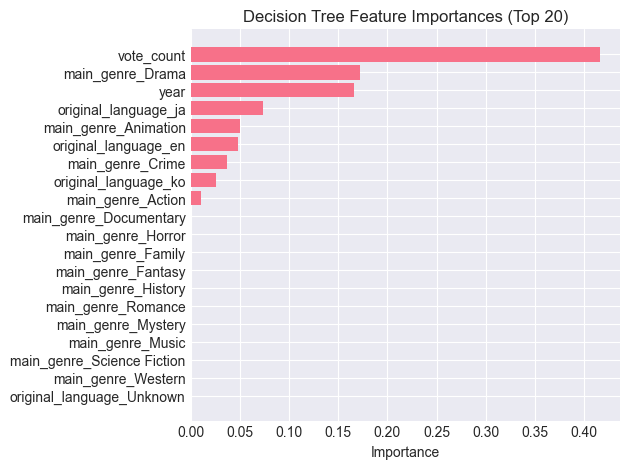

In [30]:
# Feature importance
importances = clf.feature_importances_
fi = pd.DataFrame({"feature": final_feature_names, "importance": importances})
fi = fi.sort_values("importance", ascending=False).head(20)
print("\n Most Feature Importance:\n", fi)

# Bar Graph
plt.figure()
plt.barh(fi["feature"][::-1], fi["importance"][::-1])
plt.xlabel("Importance")
plt.title("Decision Tree Feature Importances (Top 20)")
plt.tight_layout()
plt.show()

**Interpretation:**

From the feature importance, vote_count is the dominant feature having around 41.6% in prediction the movie Liked. Following vote_count, main_genre_Drama and year has the significat percentage of prediction. 
  

### Decision Tree Regression

Business UseCase: Studios can understand decision paths leading to blockbuster vs. moderate success

Why Decision Tree for Revenue Prediction?
- Captures non-linear relationships (genre + rating combinations)
- Automatically detects feature interactions
- Provides interpretable rules: "IF genre=Animation AND rating>7 THEN revenue>$150M"
- Identifies which factors drive box office success


Using features:  ['rating', 'year', 'vote_count', 'genre_drama', 'genre_comedy', 'genre_action', 'genre_adventure', 'genre_thriller', 'genre_romance', 'genre_crime', 'genre_family', 'genre_fantasy', 'genre_science fiction', 'genre_animation', 'genre_horror', 'genre_mystery', 'genre_history', 'genre_nan']

Decision Tree Regression
--------------------------------------

MAE:  $64.32M
RMSE: $128.71M
R²:   0.5702 (57.0% variance explained)


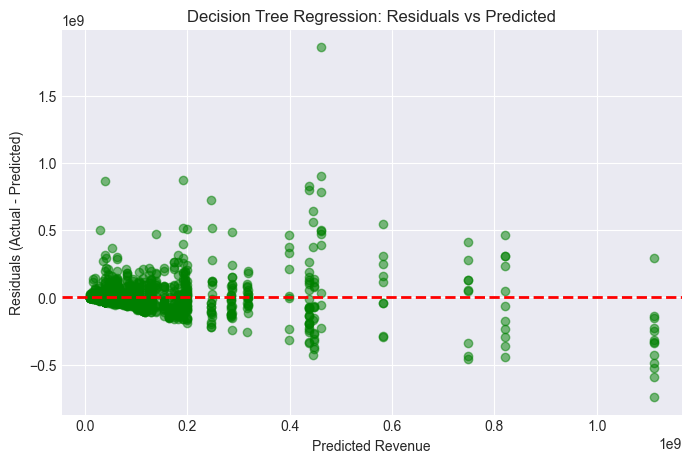

In [38]:
# Train Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(
    max_depth=10,
    min_samples_split=50,
    min_samples_leaf=20,
    random_state=42
)
pre_release_features = [
    'rating', 
    'year', 
    'vote_count',
    'genre_drama', 
    'genre_comedy', 
    'genre_action', 
    'genre_adventure', 
    'genre_thriller', 
    'genre_romance', 
    'genre_crime', 
    'genre_family', 
    'genre_fantasy', 
    'genre_science fiction', 
    'genre_animation', 
    'genre_horror', 
    'genre_mystery', 
    'genre_history', 
    'genre_nan'
]
print("Using features: ",pre_release_features)
work['vote_count'] = df['vote_count']
X_dtr = work[pre_release_features].copy()
y_dtr = work['revenue'].copy()

X_train_dtr, X_test_dtr, y_train_dtr, y_test_dtr = train_test_split(X_dtr, y_dtr, test_size=0.30, random_state=42, stratify=y)

dt_regressor.fit(X_train_dtr, y_train_dtr)
dtr_pred = dt_regressor.predict(X_test_dtr)
# Evaluate
dt_mae = mean_absolute_error(y_test_dtr, dtr_pred)
dt_rmse = sqrt(mean_squared_error(y_test_dtr, dtr_pred))
dt_r2 = r2_score(y_test_dtr, dtr_pred)

results.append(evaluate_model("Decision Tree Regression", dt_mae, dt_rmse, dt_r2))
print(f"\nDecision Tree Regression")
print(f"--------------------------------------")
print(f"\nMAE:  ${dt_mae/1e6:.2f}M")
print(f"RMSE: ${dt_rmse/1e6:.2f}M")
print(f"R²:   {dt_r2:.4f} ({dt_r2*100:.1f}% variance explained)")

# Residual plot
residuals_dt = y_test_dtr - dtr_pred
plt.figure(figsize=(8,5))
plt.scatter(dtr_pred, residuals_dt, alpha=0.5, color='green')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Predicted Revenue")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Decision Tree Regression: Residuals vs Predicted")
plt.show()


TOP 10 REVENUE DRIVERS (Decision Tree)
----------------------------------------------------
        Feature  Importance
     vote_count        0.77
genre_adventure        0.17
           year        0.02
         rating        0.02
genre_animation        0.01
   genre_family        0.01
   genre_action        0.00
 genre_thriller        0.00
   genre_comedy        0.00
    genre_drama        0.00


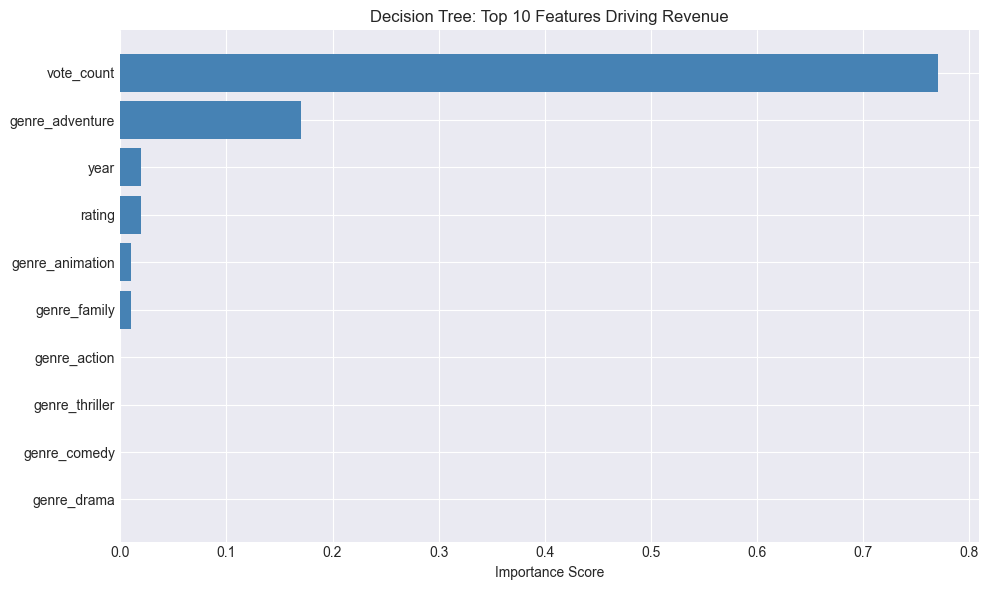


The primary revenue driver according to Decision Tree is: vote_count


In [39]:
### Feature Importance for Revenue Prediction
feature_importance_dt = pd.DataFrame({
    'Feature': X_dtr.columns,
    'Importance': np.round(dt_regressor.feature_importances_, 2)
}).sort_values('Importance', ascending=False)

print("\nTOP 10 REVENUE DRIVERS (Decision Tree)")
print("----------------------------------------------------")
print(feature_importance_dt.head(10).to_string(index=False))

# Visualize top features
plt.figure(figsize=(10,6))
top_features_dt = feature_importance_dt.head(10)
plt.barh(top_features_dt['Feature'], top_features_dt['Importance'], color='steelblue')
plt.xlabel("Importance Score")
plt.title("Decision Tree: Top 10 Features Driving Revenue")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\nThe primary revenue driver according to Decision Tree is: {feature_importance_dt.iloc[0]['Feature']}")

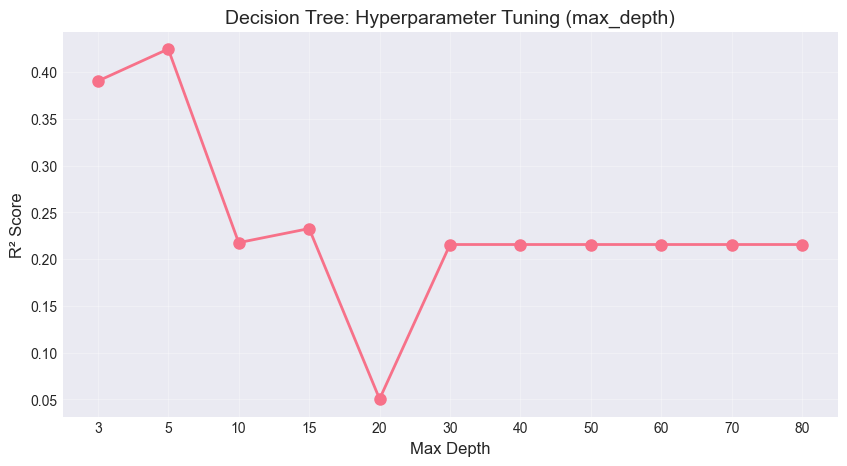

Best max_depth: 5 with R²=0.425

Decision Tree Regression ( best_depth-5 ) 
--------------------------------------

MAE:  $ 69.16 M
RMSE: $ 148.91 M
R²: 0.4247 (42.5 % variance explained)


In [40]:
### Hyperparameter Tuning for Decision Tree
# Test different max_depth values
depths = [3, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
dt_results = []

for depth in depths:
    bdt_model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    bdt_model.fit(X_train_dtr, y_train_dtr)
    y_pred = bdt_model.predict(X_test_dtr)
    mae_dt = mean_absolute_error(y_test_dtr, y_pred)
    rmse_dt = sqrt(mean_squared_error(y_test_dtr, y_pred))
    r2 = r2_score(y_test_dtr, y_pred)
    dt_results.append({'max_depth': str(depth), 'MAE': mae_dt, 'RMSE': rmse_dt, 'R²': r2})

# Plot results
dt_df = pd.DataFrame(dt_results)
plt.figure(figsize=(10, 5))
plt.plot(range(len(depths)), dt_df['R²'], marker='o', linewidth=2, markersize=8)
plt.xticks(range(len(depths)), dt_df['max_depth'])
plt.xlabel('Max Depth', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.title('Decision Tree: Hyperparameter Tuning (max_depth)', fontsize=14)
plt.grid(alpha=0.3)
plt.show()

# Find best depth
best_depth_idx = dt_df['R²'].idxmax()
best_depth = depths[best_depth_idx]
print(f"Best max_depth: {best_depth} with R²={dt_df.loc[best_depth_idx, 'R²']:.3f}")

best_mae = dt_df.loc[best_depth_idx, 'MAE']
best_rmse = dt_df.loc[best_depth_idx, 'RMSE']
best_r2 = dt_df.loc[best_depth_idx, 'R²']

results.append(evaluate_model(f"Decision Tree Regression(best_depth-{best_depth})", best_mae, best_rmse, best_r2))
print(f"\nDecision Tree Regression ( best_depth-{best_depth} ) ")
print(f"--------------------------------------")
print(f"\nMAE:  $ {best_mae / 1e6:.2f} M")
print(f"RMSE: $ {best_rmse / 1e6:.2f} M")
print(f"R²: {best_r2:.4f} ({best_r2 * 100:.1f} % variance explained)")

## Model Comparison



FINAL MODEL COMPARISON - REVENUE PREDICTION PERFORMANCE
----------------------------------------------------------------
                            Model Name          MAE         RMSE    R²
      LR(Foriegn Vs Worldwide revenue)  31747183.53  50958811.22 0.944
                        KNN (best_k=3)  36609524.50  60798661.01 0.921
                             KNN (k=5)  37126611.55  63412641.77 0.914
     LR(Domestic Vs Worldwide revenue)  48773122.42  83503795.00 0.851
              Decision Tree Regression 101448714.76 180290922.69 0.157
Decision Tree Regression(best_depth-5) 103143284.88 181127730.85 0.149
       LR(Rating Vs Worldwide revenue) 119063936.33 214139727.84 0.025
         LR(Year Vs Worldwide revenue) 117109353.79 215576457.63 0.004


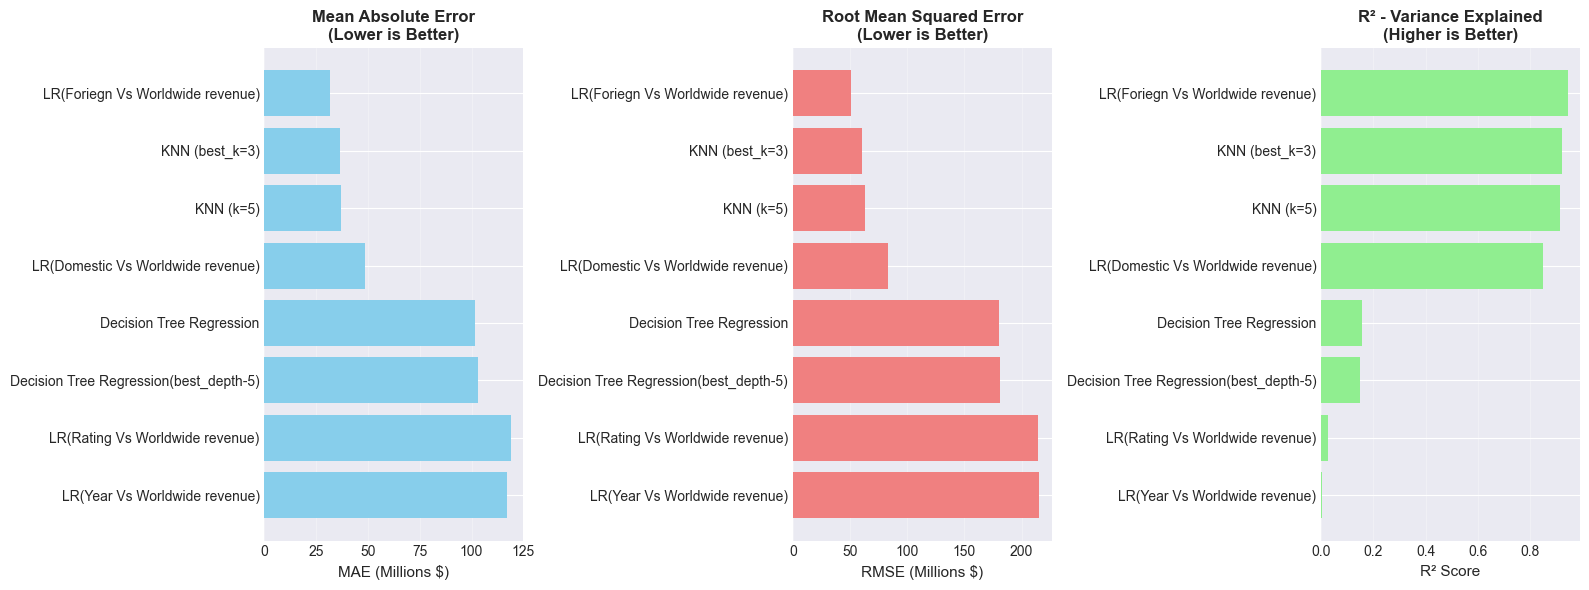

In [41]:
# Display all results in a table
comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.drop_duplicates(subset=['Model Name'], keep='first')
comparison_df = comparison_df.sort_values('R²', ascending=False)

print("\nFINAL MODEL COMPARISON - REVENUE PREDICTION PERFORMANCE")
print("----------------------------------------------------------------")
print(comparison_df.to_string(index=False))

# Visualize comparison across all metrics
fig, axes = plt.subplots(1, 3, figsize=(16,6))

models = comparison_df['Model Name'].str[:40]  # Truncate long names

# MAE Comparison
axes[0].barh(models, comparison_df['MAE']/1e6, color='skyblue')
axes[0].set_xlabel('MAE (Millions $)', fontsize=11)
axes[0].set_title('Mean Absolute Error\n(Lower is Better)', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# RMSE Comparison
axes[1].barh(models, comparison_df['RMSE']/1e6, color='lightcoral')
axes[1].set_xlabel('RMSE (Millions $)', fontsize=11)
axes[1].set_title('Root Mean Squared Error\n(Lower is Better)', fontsize=12, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

# R² Comparison
axes[2].barh(models, comparison_df['R²'], color='lightgreen')
axes[2].set_xlabel('R² Score', fontsize=11)
axes[2].set_title('R² - Variance Explained\n(Higher is Better)', fontsize=12, fontweight='bold')
axes[2].invert_yaxis()
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [42]:
# Identify best model
best_model = comparison_df.iloc[0]
print(f"\nOptimal MODEL FOR REVENUE PREDICTION:")
print(f"   Model: {best_model['Model Name']}")
print(f"   R² Score: {best_model['R²']:.3f} ({best_model['R²']*100:.1f}% of variance explained)")
print(f"   RMSE: ${best_model['RMSE']/1e6:.2f}M (typical prediction error)")
print(f"   MAE: ${best_model['MAE']/1e6:.2f}M (average deviation)")



Optimal MODEL FOR REVENUE PREDICTION:
   Model: LR(Foriegn Vs Worldwide revenue)
   R² Score: 0.944 (94.4% of variance explained)
   RMSE: $50.96M (typical prediction error)
   MAE: $31.75M (average deviation)
